In [1]:
import pandas as pd
import os
import glob 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import torch
import wandb
import sklearn.metrics
import matplotlib

In [2]:
FONTSIZE = 22
TICK_FONT = {
    "fontsize": 20,
    "fontweight": "normal"
}

def modify_font(fontsize=22, ticksize=20, titlesize=24):
    global FONTSIZE
    global TICK_FONT
    FONTSIZE = fontsize
    TICK_FONT = {
        "fontsize": ticksize,
        "fontweight": "normal"
    }

    matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Verdana']})
    matplotlib.rc('text', usetex=False)
    matplotlib.rc('font', size=FONTSIZE)
    matplotlib.rc('xtick', labelsize=ticksize)
    matplotlib.rc('ytick', labelsize=ticksize)
    matplotlib.rc('figure', titlesize=titlesize)
    matplotlib.rc('axes', titlesize=titlesize)

modify_font(fontsize=22, ticksize=20, titlesize=24)

In [3]:
def download_file(run_id, filename, project="<>/<>", force_redownload=False):
    api = wandb.Api()
    run = api.run(f"{project}/{run_id}")
    files = run.files()
    for file in files:
        if file.name == filename:
            return _download(
                file, f"./data/{run_id}/", force_redownload=force_redownload
            )
        
def _download(file, path, force_redownload=False):
    full_path = os.path.join(path, file.name)
    if os.path.exists(full_path) and not force_redownload:
        return full_path
    else:
        file.download(path, replace=True)
        return full_path

In [4]:
def get_oodd_rocauc(x_in, x_out):
    y_score = np.concatenate([x_in, x_out])
    y_true = np.concatenate([np.zeros_like(x_in), np.ones_like(x_out)])
    return sklearn.metrics.roc_auc_score(y_true, y_score)

In [5]:
color_datasets = ['FFHQ32Dequantized val', 'CIFAR10Dequantized val', 'CIFAR100Dequantized val', 'SVHNDequantized val']
bnw_bin = ['MNISTBinarized val',
 'Omniglot28x28Binarized val',
 'KMNISTBinarized val',
 'notMNISTBinarized val',
 'FashionMNISTBinarized val',
 'Omniglot28x28InvertedBinarized val']
bnw_cont = [
 'notMNISTDequantized val',
 'MNISTDequantized val',
 'Omniglot28x28InvertedDequantized val',
 'FashionMNISTDequantized val',
 'KMNISTDequantized val',
 'Omniglot28x28Dequantized val',
 'SmallNORB28x28Dequantized val',
]

# Get scores

In [6]:
score_runs = {
#     key: wandb run id
}
complexities_run_id="<>"    

In [7]:
score_paths = {}
score_data = {}
for name, rid in score_runs.items():
    print("fetching", name)
    path = download_file(rid, "all-scores.pt", force_redownload=False)
    data = torch.load(path)
    score_paths[name] = path
    score_data[name] = data

path = download_file(complexities_run_id, "complexity.pt", force_redownload=False)
complexities = torch.load(path)

fetching color_big
fetching color_nats
fetching bin_nats
fetching bin_vanilla
fetching color_vanilla
fetching bin_gauss


# Table functions 

In [8]:
ood_metrics = ["AUROC", "AUPRC", "FPR80"]
cols = ['statistic', "run_id"] + ood_metrics

jakobs_results = {
    'FashionMNIST MNIST': [0.964, 0.961, 0.036],
    'CIFAR10 SVHN': [0.811, 0.837, 0.394],
    'FashionMNIST MNISTBinarized': [0.964, 0.961, 0.036],
    'CIFAR10 SVHNDequantized': [0.811, 0.837, 0.394],
}

jakobs_in = {"FashionMNIST", "CIFAR10"}
 
stat_name_map = {
    "2 scores": "LLR-2",
    "0 elbos_k": "ELBO",
} 

def line(latex):
    if latex:
        return "\hline\n"
    else:
        return "-" * 50 + "\n"
    
def endline(latex):
    if latex:
        return "\\\\\n"
    else:
        return "\n"

def header(text, latex):
    if latex:
        return f"\\multicolumn{{4}}{{c}}{{\\textbf{{ {text} }} }}" + "\\\\\n"
    else:
        return text + "\n"  

In [9]:


replace_stats = [
    (" A", " (mode)"),
    (" B", " (sample all)"),
]

def stat_name_r(name):
    for pattern, replacement in replace_stats:
        name = name.replace(pattern, replacement)
    return name

In [10]:
def get_scores_and_comps(data, ref_ds, ds, k, run_id, score_name):
    scores = np.array(data[ref_ds][ds][k][run_id][score_name])
    comps = np.array(complexities[ds])
    
    if len(scores) != len(comps):
        scores = scores[:10000]
        comps = comps[:10000]
    return scores, comps

def get_ref_offset(run_name, ref_ds, k, score_name):
    data = score_data[run_name]
    ood_datasets = list(sorted(data[ref_ds].keys()))
    run_ids = list(sorted(data[ref_ds][ood_datasets[0]][0].keys()))
    if len(run_ids) > 1:
        print("multiple runs", reference_dataset, run_ids)    
    run_id = run_ids[0]
    ref_d = ref_ds + " val"
    scores_in, comps_in = get_scores_and_comps(data, ref_ds, ref_d, k, run_id, score_name)
    z = np.polyfit(comps_in, scores_in, 1)
    ref_p = np.poly1d(z)
    
    scores_in_offset = scores_in - ref_p(comps_in)
    return ref_p, scores_in, scores_in_offset

In [11]:
   
def print_jakobs(jakobs, a, remaining, latex, metric="AUROC"):
    metric_ind = ood_metrics.index(metric)
    result_str = ""
    if jakobs and a in jakobs_in:
        result_str += f"{'Jakobs LLR-2':19}"
        for b in remaining:
            if f"{a} {b}" in jakobs_results:
                result_str += f'|  {jakobs_results[f"{a} {b}"][metric_ind]:.3f}         '
            else:
                result_str += f"|  {'-':14s}"
        result_str += endline(latex)
    return result_str

def get_value_display(x, mx, best_margin, latex):
        if np.abs(x - mx) <= best_margin:
            if latex:
                return f" \\textbf{{{x:.3f}}} "
            else:
                return f"_{x:.3f}_"
        else:
            return f" {x:.3f} "
    

def print_scores(remaining, stat, scores, scores_max, latex, best_margin, offset_in_brackets=False):
    result_str = ""
    for b in remaining:
        if stat in scores[b] and scores[b] is not None:
            x = scores[b][stat]
            x_disp = get_value_display(x, scores_max[b], best_margin, latex)
            
            if offset_in_brackets and (stat + " (*)") in scores[b]:
                x_off = scores[b][(stat + " (*)")]
                x_off_disp = get_value_display(x_off, scores_max[b], best_margin, latex)
                
                if latex:
                    result_str += f"|{x_disp} ({x_off_disp}) "
                else:
                    result_str += f"|{x_disp}({x_off_disp})"
            else:
                result_str += f"|{x_disp}"
                if not latex: 
                    result_str += "         "
        else:
            result_str += f"|  {'-':14s}"
    return result_str

def print_all_scores(statistics, remaining, scores, scores_list, latex, best_margin=0.002, 
                     offset_in_brackets=False, hlines=False):
    result_str = ""
    for i, stat in enumerate(statistics):
        if i != 0 and hlines and "(*)" not in stat:
            result_str += line(latex)
        stat_name = stat_name_map[stat] if stat in stat_name_map else ">" + stat
        stat_name = stat_name_r(stat_name)
        if latex:
            result_str += f"{stat_name}"
        else:
            result_str += f"{stat_name[:19]:19s}"

        result_str += print_scores(remaining, stat, scores, scores_list, latex, best_margin, offset_in_brackets)

        result_str += endline(latex)
    result_str += line(latex)
    return result_str

def print_headers(a, remaining, latex, metric="AUROC"):
    result_str = ""
    setup = f"{a} (in) - [{metric}]"
    result_str += line(latex)
    result_str += header(setup, latex)
    result_str += line(latex)
    if latex:
        result_str += f"{'statistic'} & " + " & ".join(f"{m}" for m in remaining)
    else:
        result_str += f"{'statistic':19}| " + "| ".join(f"{m[:15]:15s}" for m in remaining)
        
    result_str += endline(latex)
    result_str += line(latex)
    return result_str
    

def combine_scores(scores_max_a, scores_max_b, scores_a, scores_b):
    scores_max = {}
    for key in set(scores_max_a.keys()) | set(scores_max_b.keys()):
        if key in scores_max_a and key in scores_max_b:
            scores_max[key] = max(scores_max_a[key], scores_max_b[key])
        elif key in scores_max_a:
            scores_max[key] = scores_max_a[key]
        else:
            scores_max[key] = scores_max_b[key]
            
    for ds, stats in scores_b.items():
        for k, v in stats.items():
            scores_a[ds][k] = v
    return scores_max, scores_a
            
def get_order_fn(all_statistics):
    def _fn(stat_name):
        if "complexity" in stat_name:
            return "zzz"
        name = stat_name.replace(" (*)", "").replace(". ", "")
        score_idx = all_statistics.index(name)
        k = int(name.split()[0])
        score_name = name.split()[1]
        rest = len(name.split()) + len(stat_name.split())
        return f"{score_idx} {k} {rest}"
    return _fn
    
def order_statistics(all_statistics, statistics, offset_statistics):
    return sorted(all_statistics, key=get_order_fn(all_statistics))
    

In [12]:
def get_ds_name(ds_key):
    return ds_key.replace("Binarized", "").replace("Quantized", "").replace("Dequantized", "").split()[0]

In [13]:
caption_strings = {
    "color_big": "color datasets",
    'color_nats': "color datasets",
    "bin_vanilla": "binarized black and white datasets",
    "color_vanilla": "color datasets",
    "bin_gauss": 'non-binarized (continuous) black and white datasets',
}

# all latex/string hotfixes 
FIRST = True
LAST = False
def complete_str(result_str, latex, run_name, columns_count):
    result_str = result_str.replace(">complexity", " complexity")
    result_str = result_str.replace(">. ", ". >")
    result_str = result_str.replace(">0", "")
    result_str = result_str.replace(">(*) ", "(*) >")
    if latex:
        result_str = result_str.replace(">2 LLR", " $LLR^{>2}$")
        result_str = result_str.replace(" (*)", " $^{(*)}$")
        result_str = result_str.replace("_","\\_").replace("|","&")
        result_str = result_str.replace("28x28","")\
                                .replace("Inverted","")
        cont_float = "\\ContinuedFloat"
        result_str = f"""
\\begin{{table}}[H]
{cont_float if not FIRST else ''}
\\begin{{subtable}}{{\\textwidth}}
\\centering
\\begin{{tabular}}{{|l|{'|'.join(['c'] * columns_count)}|}}
""" + result_str
        result_str += f"""
    \\end{{tabular}}
    \\caption{{{caption_strings[run_name]}}}
    \\label{{tab:ood_{run_name}}}
    \\end{{subtable}}
     %  id: {score_runs[run_name]}"""
        if LAST:
            result_str += """
\caption{OODD AUCROC scores for different groups of datasets. (*) denotes complexity offset.}\label{tab:hvae_oodd}
\end{table}
            """
        else:
            result_str += """
\\end{table}
            """
    else:
        result_str = f"----\n{run_name} {score_runs[run_name]}\n----\n" + result_str
    return result_str

In [14]:
def create_table3(run_name, statistics, offset_statistics=tuple(), 
                  offset_disp="brackets", # brackets or row or None
                  hlines=False,
                  latex=False, jakobs=True, metric="AUROC", best_margin=0.002):
    all_scores = {}
    
    data = score_data[run_name]
    
    results = []
    result_str = ""
        
    group = list(sorted(data.keys()))
    columns_count = 0
    for ref_ds in group:
        a = get_ds_name(ref_ds)
        all_statistics = [x for x in statistics]
        
        if a in skip_datasets:
            continue
            
        ood_datasets_keys = list(sorted(k for k in data[ref_ds].keys() 
                                        if k.split()[0] != ref_ds and get_ds_name(k) not in skip_datasets_val))
        ood_datasets_names = [get_ds_name(ds) for ds in ood_datasets_keys]
        
        # count columns for correct display 
        if len(ood_datasets_keys)+1 > columns_count: columns_count = len(ood_datasets_keys)+1
        
        # table print
        result_str += print_headers(a, ood_datasets_names + ['all'], latex, metric)
        result_str += print_jakobs(jakobs, a, ood_datasets_names + ['all'], latex)
        
        run_id = list(sorted(data[ref_ds][ood_datasets_keys[0]][0].keys()))[0]
        
        results = defaultdict(dict)
        
        for stat in statistics:
            score_name = " ".join(stat.split()[1:])
            
            sign = 1
            if score_name in ["ELBO"]:
                sign = -1
                    
            if stat == 'complexity':
                scores_in = np.array(complexities[ref_ds + ' val'])
            else:
                k = int(stat.split()[0])
                # get complexity offset and in domain scores
                ref_p, scores_in, scores_in_offset = get_ref_offset(run_name, ref_ds, k, score_name)
            
            
            # iterate OOD datasets
            all_odd_scores = []
            all_odd_scores_offset = []
            
            for ood_key in ood_datasets_keys:
                
                ood_name = get_ds_name(ood_key)
                
                # get ood scores 
                if stat == 'complexity':
                    scores_out = np.array(complexities[ood_key])
                else:
                    scores_out, comps_out = get_scores_and_comps(data, ref_ds, ood_key, k, run_id, score_name)
                    
                # compute AUCROC
                roc_auc = get_oodd_rocauc(sign * scores_in, sign * scores_out)
                
                # save stats
                results[ood_name][stat] = roc_auc
                all_odd_scores.append(scores_out)
                
                if stat in offset_statistics:
                    # offset complexity and compute AUCROC
                    scores_offset = scores_out - ref_p(comps_out)
                    roc_auc_offset = get_oodd_rocauc(sign * scores_in_offset, sign * scores_offset)
                    
                    # save stats
                    results[ood_name][f"{stat} (*)"] = roc_auc_offset
                    all_odd_scores_offset.append(scores_offset)
                
            
            # compute against all
            all_odd_scores = np.concatenate(all_odd_scores)
            results['all'][stat] = get_oodd_rocauc(sign * scores_in, sign * all_odd_scores)
            
            if stat in offset_statistics:
                all_odd_scores_offset = np.concatenate(all_odd_scores_offset)
                results['all'][f"{stat} (*)"] = get_oodd_rocauc(sign * scores_in_offset, 
                                                                sign * all_odd_scores_offset)

            
            # add keys to print later
            if stat in offset_statistics and  offset_disp == 'row':
                all_statistics.append(f"{k} {score_name} (*)")
        
        # find max scores to bold
        results_max = {ood_name: max(results_dict.values()) for ood_name, results_dict in results.items()}
        
        # fix order
        if offset_disp == 'row':
            all_statistics = order_statistics(all_statistics, statistics, offset_statistics)
        
        # print all scores for this in-dataset 
        result_str += print_all_scores(all_statistics, ood_datasets_names + ['all'], results, 
                                       results_max, latex, best_margin, offset_disp=="brackets", hlines=hlines)
        
        all_scores[a] = results
        
    result_str = complete_str(result_str, latex, run_name, columns_count)
    
    return all_scores, result_str

## tables 1

In [ ]:
skip_datasets = {"Omniglot28x28", "Omniglot28x28Inverted", "SmallNORB28x28", "notMNIST"}

skip_datasets_val = {"SmallNORB28x28", "Omniglot28x28"}

stats = [
        '2 LLR',
        '0 ELBO', 
        "0 p_var_0",
        "0 p_var_1",
#         '0 KL',
        'complexity'
    ]
off_stats = [
        '0 ELBO', 
        "0 p_var_0",
        "0 p_var_1",
#         '0 KL',
    ]


all_scores = {}
all_tables = ""
FIRST = True
LAST = False

for i, k in enumerate(['bin_gauss', 'bin_vanilla', 'color_nats']):
    if i == 2: LAST = True
    all_scores[k], result_str = create_table3(k, stats, off_stats, latex=True, offset_disp="row", hlines=True, jakobs=False);
    
    FIRST = False
    
    all_tables += "\n\n" + result_str

print(all_tables)



# Scatterplots

In [67]:
from matplotlib.ticker import FormatStrFormatter, NullFormatter

ds_colors = {
 'notMNIST': "k",
 'KMNIST': "k",
 'FashionMNIST': "k",
 'Omniglot28x28': "k",
 'MNIST': "k",
 'SmallNORB28x28': "k",
 'Omniglot28x28Inverted': "k",
 'CIFAR100': "r",
    'CIFAR10': "m",
    'SVHN': "c",
    'FFHQ32': "y",
 'all': 'k',
}
run_markers = {
    'bin_gauss': "x", 
    'bin_vanilla': "+", 
    'color_nats': "."
}
run_sizes = {
    'bin_gauss': 6, 
    'bin_vanilla': 7, 
    'color_nats': 10
}
MS = 10
def get_marker_kwargs(run_name, in_d, out_d):
    if out_d == "all":
        return [{
            "ms": MS,
            "mew": 1,
            "marker": '*',
            "mfc": "none", #ds_colors[in_d],
            "markeredgecolor": ds_colors[in_d]
        }]
    
    kwargs1 = {
        "ms": run_sizes[run_name],
        "mew": 2 if run_markers[run_name] == '.' else 1,
        "marker": run_markers[run_name],
        "mfc": 'none',
        "markeredgecolor": ds_colors[in_d]
    }
    
    if run_name != "color_nats":
        return [kwargs1]
    kwargs2 = {
        "ms": run_sizes[run_name],
        "mew": 1,
        "marker": "o",
        "mfc": 'none',
        "markeredgecolor": ds_colors[out_d]
    }
    return [kwargs1, kwargs2]
    

eps = 0.001
ticks_min = np.arange(0,1,0.1)
ticks_maj = [0, 0.5, 1]

def scatter_compare_oodd(x, y, small=False):
    if small:
        fsize = 2.7
        lpad = -10
        ticks_maj_txt = ["0", "", "1"]
    else:
        fsize = 3.5
        lpad = -1
        ticks_maj_txt = ["0", ".5", "1"]
        
    x_name = rename_stat(x)
    y_name = rename_stat(y)
    plt.figure(figsize=(fsize,fsize))
    x_count = 0
    y_count = 0
    for run_name, d0 in all_scores.items():
        for in_d, d1 in d0.items():
            for out_d, results in d1.items():
                for kwargs in get_marker_kwargs(run_name, in_d, out_d):
                    plt.plot(results[x], results[y], **kwargs)
                diff = results[x] - results[y]
                if diff > eps:
                    x_count += 1
                elif diff < - eps:
                    y_count += 1
    plt.xlabel(x_name, labelpad=lpad)
    plt.ylabel(y_name, labelpad=lpad)
    plt.xlim((-0.02,1.02))
    plt.ylim((-0.02,1.02))
    plt.plot([0,1], [0,1], "k--")
    ax = plt.gca()

    ax.set_xticks(ticks_min, minor=True)
    ax.set_yticks(ticks_min, minor=True)
    ax.set_xticks(ticks_maj, minor=False)
    ax.set_yticks(ticks_maj, minor=False)
    
    plt.xticks(ticks_maj, ticks_maj_txt)
    plt.yticks(ticks_maj, ticks_maj_txt)
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    
    ax.grid(which="major")
    ax.grid(which="minor", linestyle='--', alpha=0.2)
#     plt.title(f"OODD AUROC {x_name} vs {y_name} ({x_count} : {y_count})")
    print(f"({x_count} : {y_count})")
#     plt.title(f"OODD AUROC {x_name} vs {y_name}")


In [68]:
def rename_stat(s):
    if s.startswith("0 "):
        s = s[2:]
    s = s.replace("2 LLR", "$LLR^{>2}$")
    s = s.replace(" (*)", "$^{(*)}$")
    return s

In [149]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def custom_legend(loc=(0.8,0.05), colors=True, markers=True):
    legend_elements = []
    if markers:
        legend_elements += [
                               Line2D([0], [0],
                                      linestyle='none',
                                      label='B&W - continuous',
                                      **get_marker_kwargs("bin_gauss", "MNIST", "MNIST")[0]
                                ),
                               Line2D([0], [0], 
                                      linestyle='none',
                                      label='B&W - binarized',
                                      **get_marker_kwargs("bin_vanilla", "MNIST", "MNIST")[0]
                                ),
                               Line2D([0], [0], 
                                      linestyle='none',
                                      label='All OOD',
                                      **get_marker_kwargs("bin_vanilla", "MNIST", "all")[0]
                                ),
                               Line2D([0], [0], 
                                      linestyle='none',
                                      label='Color: in-domain',
                                        ms=MS,
                                        mew=1,
                                        marker=".",
                                        mfc='none',
                                        markeredgecolor='k'
                                ),
                               Line2D([0], [0], 
                                      linestyle='none',
                                      label='Color: ood',
                                        ms=MS,
                                        mew=1,
                                        marker="o",
                                        mfc='none',
                                        markeredgecolor='k'
                                )]

    if colors:
        legend_elements += [
            Patch(
                facecolor=ds_colors[ds],
                label=f'  {ds}') for ds in ["CIFAR10", "CIFAR100", "SVHN", "FFHQ32"]
        ]

    plt.legend(handles=legend_elements, loc=loc)

In [150]:
fsize = 3.5
modify_font(fontsize=13, ticksize=10, titlesize=15)

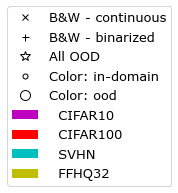

In [151]:
plt.figure(figsize=(2,2))
plt.gca().set_axis_off()
custom_legend(loc=(0,0))
plt.savefig("fig/legend.pdf", bbox_inches='tight')

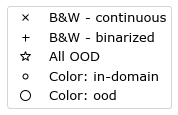

In [155]:
plt.figure(figsize=(2,1))
plt.gca().set_axis_off()
custom_legend(loc=(0,0), colors=False)
plt.savefig("fig/legend_markers.pdf", bbox_inches='tight')

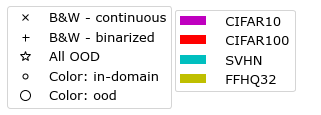

In [168]:
plt.figure(figsize=(5.5,1))
plt.subplot(1,2,1)
plt.gca().set_axis_off()
custom_legend(loc=(0,0), colors=False)
plt.subplot(1,2,2)
plt.gca().set_axis_off()
custom_legend(loc=(0,0.3), markers=False)
plt.savefig("fig/legend_flat.pdf", bbox_inches='tight')

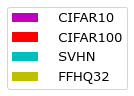

In [154]:
plt.figure(figsize=(2,1))
plt.gca().set_axis_off()
custom_legend(loc=(0,0), markers=False)
plt.savefig("fig/legend_colors.pdf", bbox_inches='tight')

(3 : 28)


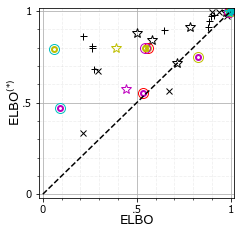

In [72]:
scatter_compare_oodd('0 ELBO','0 ELBO (*)')
# custom_legend(loc=(0.95,0.05))
plt.savefig("fig/elbo_elbo_s.pdf", bbox_inches='tight')

(25 : 16)


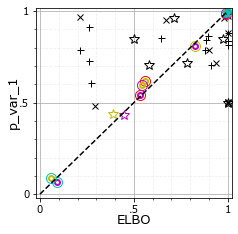

In [73]:
scatter_compare_oodd('0 ELBO','0 p_var_1')
# custom_legend(loc=(1,0.05))
plt.savefig("fig/elbo_p_var_1.pdf", bbox_inches='tight')

(16 : 25)


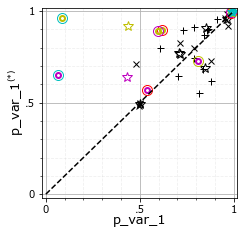

In [74]:
scatter_compare_oodd('0 p_var_1','0 p_var_1 (*)')
# custom_legend(loc=(1,0.05))
plt.savefig("fig/p_var_1_p_var_1_s.pdf", bbox_inches='tight')

In [82]:
# scatter_compare_oodd('0 p_var_0 (*)','0 p_var_1 (*)')
# custom_legend(loc=(1.02,0.05))

(24 : 16)


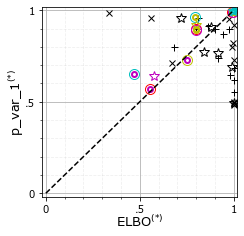

In [76]:
scatter_compare_oodd('0 ELBO (*)','0 p_var_1 (*)')
plt.savefig("fig/elbo_s_p_var_1_s.pdf", bbox_inches='tight')

(26 : 16)


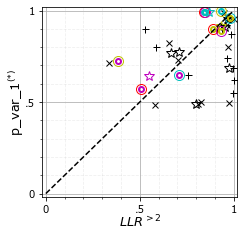

In [77]:
scatter_compare_oodd('2 LLR','0 p_var_1 (*)')
plt.savefig("fig/llr_2_p_var_1_s.pdf", bbox_inches='tight')

(15 : 26)


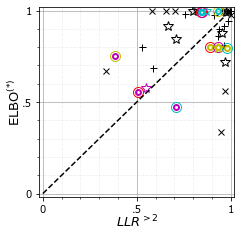

In [78]:
scatter_compare_oodd('2 LLR','0 ELBO (*)')
plt.savefig("fig/llr_2_elbo_s.pdf", bbox_inches='tight')

(1 : 39)


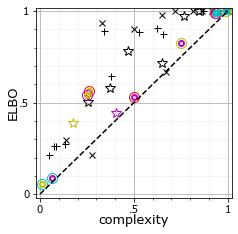

In [79]:
scatter_compare_oodd('complexity', '0 ELBO')
plt.savefig("fig/complexity_elbo.pdf", bbox_inches='tight')

(1 : 39)


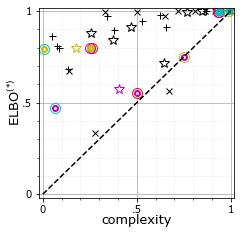

In [80]:
scatter_compare_oodd('complexity', '0 ELBO (*)')
plt.savefig("fig/complexity_elbo_s.pdf", bbox_inches='tight')

(10 : 32)


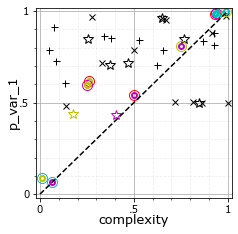

In [89]:
scatter_compare_oodd('complexity', '0 p_var_1', small=False)
plt.savefig("fig/complexity_p_var_1.pdf", bbox_inches='tight')

In [ ]:
# small

(16 : 25)


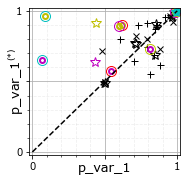

In [83]:
scatter_compare_oodd('0 p_var_1','0 p_var_1 (*)', small=True)
plt.savefig("fig/p_var_1_p_var_1_s_small.pdf", bbox_inches='tight')

(3 : 28)


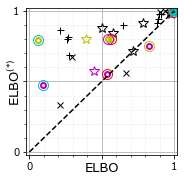

In [84]:
scatter_compare_oodd('0 ELBO','0 ELBO (*)', small=True)
plt.savefig("fig/elbo_elbo_s_small.pdf", bbox_inches='tight')

(1 : 39)


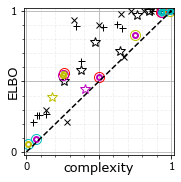

In [85]:
scatter_compare_oodd('complexity', '0 ELBO', small=True)
plt.savefig("fig/complexity_elbo_small.pdf", bbox_inches='tight')

(1 : 39)


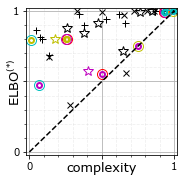

In [86]:
scatter_compare_oodd('complexity', '0 ELBO (*)', small=True)
plt.savefig("fig/complexity_elbo_s_small.pdf", bbox_inches='tight')

(25 : 16)


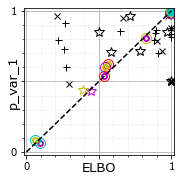

In [87]:
scatter_compare_oodd('0 ELBO','0 p_var_1', small=True)
# custom_legend(loc=(1,0.05))
plt.savefig("fig/elbo_p_var_1_small.pdf", bbox_inches='tight')

(10 : 32)


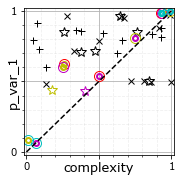

In [88]:
scatter_compare_oodd('complexity', '0 p_var_1', small=True)
plt.savefig("fig/complexity_p_var_1_small.pdf", bbox_inches='tight')